In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import re
import string,time
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import subprocess
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,r2_score,recall_score,precision_score,f1_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

UPLOADING THE DATA

In [4]:
train_data=pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
val_data=pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
test_data=pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

EDA

In [5]:
train_data.head()
val_data.head()
test_data.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [6]:
train_data.shape

(16000, 2)

In [7]:
train_data.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [8]:
train_data['text'].nunique()

15969

In [9]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [10]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

<Axes: xlabel='label_name'>

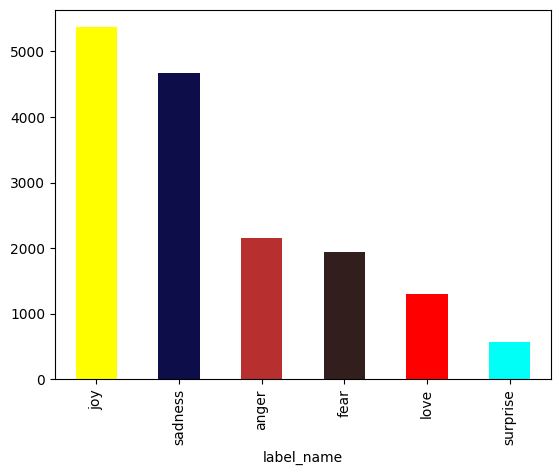

In [11]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

In [12]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


PREPROCESSING THE DATA

In [13]:
## CONVERTING TO LOWER CASE 
train_data['clean_text']=train_data['text'].str.lower()
val_data['clean_text']=val_data['text'].str.lower()

In [14]:
##REMOVING URL
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+|pic.twitter.com\S+')
    return pattern.sub(r'',text)
train_data['clean_text']= train_data['text'].apply(remove_url)
val_data['clean_text']=val_data['text'].apply(remove_url)

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('','',exclude))
train_data['clean_text']=train_data['text'].apply(remove_punc)
val_data['clean_text']=val_data['text'].apply(remove_punc)

In [17]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [18]:
##CONVERT THE ABBREVATIONS
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens=[convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
train_data['clean_text'] = train_data['text'].apply(lambda x: convert_abbrev_in_text(x))
val_data['clean_text']=val_data['text'].apply(lambda x: convert_abbrev_in_text(x))

In [19]:
## REMOVE EMOJIS
def emoji_remove(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
train_data['clean_text'] = train_data['text'].apply(lambda x: emoji_remove(x))
val_data['clean_text']=val_data['text'].apply(lambda x: emoji_remove(x))

In [20]:
##IMPORTING WORDNET
nltk.download('wordnet')
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordne

In [21]:
##LEMMATIZATION
from nltk.corpus import wordnet 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
lemmatizer = WordNetLemmatizer()
tokenizer=Tokenizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def lem_words(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag)) for token, tag in pos_tags]
    lemmatized_sentence = ' '.join(lemmatized_tokens)
    return lemmatized_sentence
train_data['clean_text'] = train_data['text'].apply(lambda text: lem_words(text))
val_data['clean_text'] = val_data['text'].apply(lambda text: lem_words(text))

In [22]:
train_data.head(400)

,text,label,label_name,clean_text
0,i didnt feel humiliated,0,sadness,i didnt feel humiliate
1,i can go from feeling so hopeless to so damned...,0,sadness,i can go from feel so hopeless to so damned ho...
2,im grabbing a minute to post i feel greedy wrong,3,anger,im grab a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,love,i be ever feel nostalgic about the fireplace i...
4,i am feeling grouchy,3,anger,i be feel grouchy
...,...,...,...,...
395,i feel is thankful for the lessons i m learning,1,joy,i feel be thankful for the lesson i m learn
396,i feel such a longing and sadness when i see f...,2,love,i feel such a longing and sadness when i see f...
397,i feel distinctly called in clermont to focus ...,2,love,i feel distinctly call in clermont to focus on...
398,i hope you can feel glad that she gave you so ...,1,joy,i hope you can feel glad that she give you so ...


BAG OF WORDS

In [23]:
data=train_data['text']
c_data=train_data['clean_text']
labels=train_data['label'] 
labelencoder = LabelEncoder()
train_data['label_encoded'] = labelencoder.fit_transform(train_data['label'])
c_labels=train_data['label_encoded'] 

1.SVM

In [56]:
params={'C':[0.1,1,10,100],'gamma':[0.0001,0.01,0.1],'kernel':['linear','rbf']}
svc = SVC()

In [32]:
## for given data
cv=CountVectorizer()
bow=cv.fit_transform(data)
X_train1,X_test1,y_train1,y_test1=train_test_split(bow,labels,test_size=0.2,random_state=42)
clf = GridSearchCV(svc, params, verbose=5)
clf.fit(X_train1,y_train1)
print(clf.best_params_)
print(clf.best_estimator_)
y_pred1=clf.predict(X_test1)
print(classification_report(y_test1,y_pred1))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.866 total time=  20.6s
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.871 total time=  20.3s
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.880 total time=  20.8s
[CV 4/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.870 total time=  20.3s
[CV 5/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.870 total time=  20.4s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.339 total time=  28.8s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.340 total time=  28.6s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.339 total time=  28.9s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.339 total time=  28.8s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.339 total time=  28.6s
[CV 1/5] END .......C=1, gamma=1, kernel=linear;, score=0.866 total time=  20.6s
[CV 2/5] END .......C=1, gamma=1, kernel=linear;,

In [45]:
## FOR CLEANED DATA
c_bow=cv.fit_transform(c_data)
X_train1_c,X_test1_c,y_train1_c,y_test1_c=train_test_split(c_bow,c_labels,test_size=0.2,random_state=42)
clf = GridSearchCV(svc, params, verbose=5)
clf.fit(X_train1_c,y_train1_c)
print(clf.best_params_)
print(clf.best_estimator_)
y_pred1_c=clf.predict(X_test1_c)
print(classification_report(y_test1_c,y_pred1_c))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.840 total time=  22.8s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.845 total time=  22.9s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.847 total time=  23.0s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.846 total time=  22.8s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.837 total time=  22.7s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.6s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.6s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.7s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.7s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.6s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.840 total time=  22.8s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

2.RFC

In [50]:
rfc=RandomForestClassifier(class_weight='balanced')
param_grid = {'max_depth': [8,10,12,15,20],'max_features': ['auto', 'sqrt','log2'], 'n_estimators': [100,200,300,500]}

In [51]:
##GIVEN DATA
clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
clf.fit(X_train1,y_train1)
print(clf.best_params_)
print(clf.best_estimator_)
y_predict1=clf.predict(X_test1)
print(classification_report(y_test1,y_predict1))

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=500)
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       946
           1       0.90      0.86      0.88      1021
           2       0.73      0.94      0.83       296
           3       0.85      0.86      0.86       427
           4       0.88      0.81      0.84       397
           5       0.63      0.99      0.77       113

    accuracy                           0.86      3200
   macro avg       0.82      0.89      0.84      3200
weighted avg       0.87      0.86      0.87      3200



In [52]:
## CLEANED DATA
clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
clf.fit(X_train1_c,y_train1_c)
print(clf.best_params_)
print(clf.best_estimator_)
y_predict1_c=clf.predict(X_test1_c)
print(classification_report(y_test1_c,y_predict1_c))

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', n_estimators=500)
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       946
           1       0.88      0.87      0.88      1021
           2       0.71      0.80      0.75       296
           3       0.85      0.84      0.85       427
           4       0.84      0.76      0.80       397
           5       0.67      0.76      0.71       113

    accuracy                           0.85      3200
   macro avg       0.81      0.82      0.81      3200
weighted avg       0.85      0.85      0.85      3200



TF-IDF

1.SVM

In [53]:
## for given data
vectorizer = TfidfVectorizer()
tf_text=vectorizer.fit_transform(data)
X_train2,X_test2,y_train2,y_test2=train_test_split(tf_text,labels,test_size=0.2,random_state=42)
clf = GridSearchCV(svc, params, verbose=5)
clf.fit(X_train2,y_train2)
print(clf.best_params_)
print(clf.best_estimator_)
y_pred2=clf.predict(X_test2)
print(classification_report(y_test2,y_pred2))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.530 total time=  27.0s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.515 total time=  27.0s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.529 total time=  27.2s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.528 total time=  27.2s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.531 total time=  27.0s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.8s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.7s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.9s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.7s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.7s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.530 total time=  27.2s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

In [57]:
## FOR CLEANED DATA
tf_text_c=vectorizer.fit_transform(c_data)
X_train2_c,X_test2_c,y_train2_c,y_test2_c=train_test_split(tf_text_c,c_labels,test_size=0.2,random_state=42)
clf = GridSearchCV(svc, params, verbose=5)
clf.fit(X_train2_c,y_train2_c)
print(clf.best_params_)
print(clf.best_estimator_)
y_pred2_c=clf.predict(X_test2_c)
print(classification_report(y_test2_c,y_pred2_c))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.529 total time=  25.8s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.520 total time=  25.9s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.537 total time=  26.1s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.537 total time=  26.0s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.532 total time=  25.9s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.3s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.2s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.3s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.3s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.339 total time=  23.2s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.529 total time=  25.8s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

2.RFC

In [58]:
## for given data
clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
clf.fit(X_train2,y_train2)
print(clf.best_params_)
print(clf.best_estimator_)
y_predict2=clf.predict(X_test2)
print(classification_report(y_test2,y_predict2))

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='auto', n_estimators=500)
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       946
           1       0.88      0.85      0.87      1021
           2       0.73      0.91      0.81       296
           3       0.87      0.83      0.85       427
           4       0.87      0.80      0.83       397
           5       0.65      0.99      0.78       113

    accuracy                           0.86      3200
   macro avg       0.82      0.87      0.84      3200
weighted avg       0.86      0.86      0.86      3200



In [ ]:
## FOR CLEANED DATA
clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
clf.fit(X_train2_c,y_train2_c)
print(clf.best_params_)
print(clf.best_estimator_)
y_predict2_c=clf.predict(X_test2_c)
print(classification_report(y_test2_c,y_predict2_c))